**Enron Fraud Exploration**
===========================

**Background**
--------------

Enron was an American energy and commodities corporation which bankrupted in 2001 after it was discovered that their reported financial condition was sustained by accounting fraud, remembered today as the Enron Scandal. 

In this project I will be analyzing the Enron email dataset in an attempt to discover which factors can be used to identify a Person of Interest (POI) in the scandal. I will be investigating the features in the data set to see if there are any interesting patterns/trends to be discovered. And finally, I will be employing machine learning classification algorithms in an attempt to build a model to predict whether or not someone is a POI.

More Information: https://en.wikipedia.org/wiki/Enron  https://en.wikipedia.org/wiki/Enron_Corpus 


In [93]:
#Import Necessary Libraries
import numpy as np
import sys
import pickle
sys.path.append("../tools/")
from math import isnan
from feature_format import featureFormat, targetFeatureSplit
from tester import (dump_classifier_and_data, load_classifier_and_data,
test_classifier)
import pandas as pd
from time import time
%matplotlib inline
from IPython.display import display
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
np.set_printoptions(threshold=np.inf)

with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
my_dataset = data_dict
print my_dataset.keys() # View the names in the dataset

['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JOHN H', 'SHAPIRO RICHARD S', 'SHERRIFF JOHN R', 'SHELBY 

In [94]:
# Check to see how many people are in the dataset
print "The dataset contains {} people.".format(len(my_dataset.keys()))
print "The number of features for each person in the data set is {}.".format(len(my_dataset['METTS MARK'].keys()))

The dataset contains 146 people.
The number of features in the data set is 21.


In [95]:
#Check the first entry to see the features
my_dataset['METTS MARK'].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

From looking at the list of names outputted above, there are two entries that seem strange:
* The travel agency in the park
* Total

Next I am going to expand these two entries and see what data they contain.

In [96]:
#Check values for THE TRAVEL AGENCY IN THE PARK and TOTAL
print "Travel agency in the park: {}".format(my_dataset['THE TRAVEL AGENCY IN THE PARK'])
print "Total: {}".format(my_dataset['TOTAL'])

Travel agency in the park: {'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 362096, 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 362096, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 'NaN', 'deferred_income': 'NaN', 'long_term_incentive': 'NaN', 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}
Total: {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi':

The travel agency in the park contains almost entirely missing data except for two vaules, "Total Payments" and "Other". Since this is obviously not an employee, and most of the data is missing, I am going to remove this entry from the data set.

The "Total" entry seems to represent a sum total of all of the numerical values from each employee, this will not be useful in the investigation, so "Total" will also be removed.

Next I am also going to check if there are any entries in the dataset containing entirely missing data.

In [97]:
#Check if anybody in the data set has all missing data
for key in my_dataset.keys():
    if my_dataset[key].values().count('NaN') >= 20:
        print key

LOCKHART EUGENE E


The name "Lockhart Eugene E" came out from my search for entries with all missing data. I will visualize this entry first to make sure that it is all NaNs, then if appropriate, I will delete it along with the other two. 

In [98]:
my_dataset['LOCKHART EUGENE E']

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 'NaN',
 'total_stock_value': 'NaN'}

In [99]:
# Remove the 3 identified entries
my_dataset.pop("TOTAL", None)
my_dataset.pop("THE TRAVEL AGENCY IN THE PARK", None)
my_dataset.pop("LOCKHART EUGENE E", None)
print "The updated dataset has {} people in it.".format(len(my_dataset.keys())) #Check to make sure keys were deleted

The updated dataset has 143 people in it.


In [100]:
target = ['poi']
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
email_features = ['email_address', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
features_list = target + financial_features + email_features
features_list

['poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'email_address',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi']

Looking through the above list of feature, the feature "email address" stands out to me as one which would not be useful in predicting POIs, so it will be removed from the data set and features list.

In [101]:
for person in my_dataset:
    del my_dataset[person]['email_address']

In [102]:
del features_list[features_list.index("email_address")]
print "The number of features in the updated data set is {}.".format(len(my_dataset['METTS MARK'].keys()))

The number of features in the updated data set is 20.


Now I am going to add the following additional features to my features list which I think could be useful in training the model:
* A "Bonus to Salary" feature which will show the ratio of each employees bonus to their salary. 
* A "Fraction From POI" feature which will represent the fraction of all from emails which were from a POI.
* A "Fraction To POI" feature which will represent the fraction of all to emails which were to a POI.

In [103]:
#Create some new features
for person in my_dataset:
    my_dataset[person]['fraction_from_poi'] = float(my_dataset[person]['from_poi_to_this_person'])/float(my_dataset[person]['from_messages'])
    my_dataset[person]['fraction_to_poi'] = float(my_dataset[person]['from_this_person_to_poi'])/float(my_dataset[person]['to_messages'])
    my_dataset[person]['bonus_to_salary'] = float(my_dataset[person]['bonus'])/float(my_dataset[person]['salary'])
print my_dataset['METTS MARK'].keys() # Make sure features were added.
                                                        

['to_messages', 'deferral_payments', 'expenses', 'poi', 'deferred_income', 'long_term_incentive', 'fraction_from_poi', 'restricted_stock_deferred', 'shared_receipt_with_poi', 'loan_advances', 'from_messages', 'other', 'director_fees', 'bonus', 'total_stock_value', 'from_poi_to_this_person', 'from_this_person_to_poi', 'restricted_stock', 'salary', 'total_payments', 'fraction_to_poi', 'exercised_stock_options', 'bonus_to_salary']


In [104]:
features = features_list + ['bonus_to_salary','fraction_from_poi','fraction_to_poi']
print "The number of features in the updated data set is {}.".format(len(my_dataset['METTS MARK'].keys()))

The number of features in the updated data set is 23.


In [105]:
for person in my_dataset:
    if np.isnan(my_dataset[person]['fraction_to_poi']):
        my_dataset[person]['fraction_to_poi']='NaN'
    if np.isnan(my_dataset[person]['fraction_from_poi']):
        my_dataset[person]['fraction_from_poi']='NaN'
    if np.isnan(my_dataset[person]['bonus_to_salary']):
        my_dataset[person]['bonus_to_salary']='NaN'

At this point I am going to investigate the date in the dataset and see if I can identify any interesting trends/patterns.

First I am going to output some descriptive statistics for each feature in the dataset to show what the distributions are like for each feature.

In [106]:
data = featureFormat(my_dataset, features, sort_keys = True)
df = pd.DataFrame(data, columns = features)
df.describe()

,poi,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi,bonus_to_salary,fraction_from_poi,fraction_to_poi
count,143.000000,143.00000,143.000000,1.430000e+02,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.125874,186742.86014,223642.629371,2.272323e+06,586888.111888,680724.608392,73931.314685,-195037.699301,2930133.762238,35622.720280,2090318.076923,296806.692308,339314.181818,874609.972028,10050.111888,1247.216783,39.027972,366.125874,24.797203,707.524476,2.165894,0.666559,0.010376
std,0.332873,197117.07164,756520.789342,8.876252e+06,6818177.361780,1236179.688487,1306545.168009,607922.474513,6205936.523955,45370.869604,4809193.248967,1135030.646187,689013.933361,2022338.365458,31399.349067,2243.006069,74.466359,1455.452279,80.031821,1079.457016,3.729059,1.659540,0.025443
min,0.000000,0.00000,-102500.000000,0.000000e+00,0.000000,0.000000,-1787380.000000,-3504386.000000,-44093.000000,0.000000,0.000000,0.000000,0.000000,-2604490.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,9.679650e+04,0.000000,0.000000,0.000000,-37506.000000,254936.000000,0.000000,0.000000,0.000000,0.000000,38276.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,210692.00000,0.000000,9.665220e+05,0.000000,300000.000000,0.000000,0.000000,976037.000000,21530.000000,608750.000000,947.000000,0.000000,360528.000000,0.000000,383.000000,4.000000,18.000000,0.000000,114.000000,1.216805,0.021412,0.000000
75%,0.000000,270259.00000,9110.000000,1.956978e+06,0.000000,800000.000000,0.000000,0.000000,2307583.500000,53534.500000,1698900.500000,149204.000000,374825.500000,775992.000000,0.000000,1639.000000,41.500000,54.000000,14.000000,967.500000,2.838435,0.581618,0.008859
max,1.000000,1111258.00000,6426990.000000,1.035598e+08,81525000.000000,8000000.000000,15456290.000000,0.000000,49110078.000000,228763.000000,34348384.000000,10359729.000000,5145434.000000,14761694.000000,137864.000000,15149.000000,528.000000,14368.000000,609.000000,5521.000000,24.532820,11.523810,0.196896


In [107]:
print "Of the {} people in the dataset, {} of them are labeled as POIs.".format(len(df),len(df[df['poi']==1]))

Of the 143 people in the dataset, 18 of them are labeled as POIs.


Next I am going to show the mean value of each feature for POIs and non-POIs and see if there are any obvious differences between the two groups.

In [108]:
df.groupby(['poi'])[features[1:]].mean()

,salary,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,exercised_stock_options,other,long_term_incentive,restricted_stock,director_fees,to_messages,from_poi_to_this_person,from_messages,from_this_person_to_poi,shared_receipt_with_poi,bonus_to_salary,fraction_from_poi,fraction_to_poi
poi,,,,,,,,,,,,,,,,,,,,,,
0,161485.328000,235051.400000,1459980.112000,19200.000000,513148.960000,84577.424,-132015.544000,2032216.408000,32130.560000,1386799.688000,223915.232000,272508.632000,685221.384,11497.328,1156.096,33.696000,385.208000,20.896000,609.712000,1.790034,0.549046,0.00876
1,362142.388889,144415.055556,7913589.777778,4529166.666667,1844444.388889,0.000,-632691.555556,9165670.944444,59873.833333,6975862.444444,802997.388889,803241.611111,2189808.500,0.000,1880.000,76.055556,233.611111,51.888889,1386.777778,4.776032,1.482623,0.02160


From looking through the above table it is obvious that there are differences between the two groups, and these are just a few observations:
* Total Payments for POIs is about 5 times higher than non-POIs.
* Total Stock Value is about 4.5 times higher for POIs.
* The three features which I added to the data set are all higher for POIs.

Next I am going to see how many missing values are present in the dataset for each feature.

In [109]:
for col in df.columns[1:]:
    print col, len(df[df[col]==0])

salary 49
deferral_payments 105
total_payments 20
loan_advances 140
bonus 62
restricted_stock_deferred 126
deferred_income 95
total_stock_value 18
expenses 49
exercised_stock_options 42
other 52
long_term_incentive 78
restricted_stock 34
director_fees 127
to_messages 57
from_poi_to_this_person 69
from_messages 57
from_this_person_to_poi 77
shared_receipt_with_poi 57
bonus_to_salary 62
fraction_from_poi 69
fraction_to_poi 77


Unfortunately, in this dataset, almost every feature has a significant amount of missing values. This will make it hard to construct a highly accurate classification model. There are several methods to deal with missing values in a dataset, for example, deleting the rows containing missing data, but because there are so many in this dataset, removing the rows would eliminate too much of the data. For now I will just move forward with the dataset how it is and do the best I can.

Next I am going to visualize a correlation matrix, which will show the correlations between each feature pair in the dataset. The red boxes represent positive correlations and the blue boxes represent negative correlations, the darker the color in each square, the stronger the relationship between the two variables.

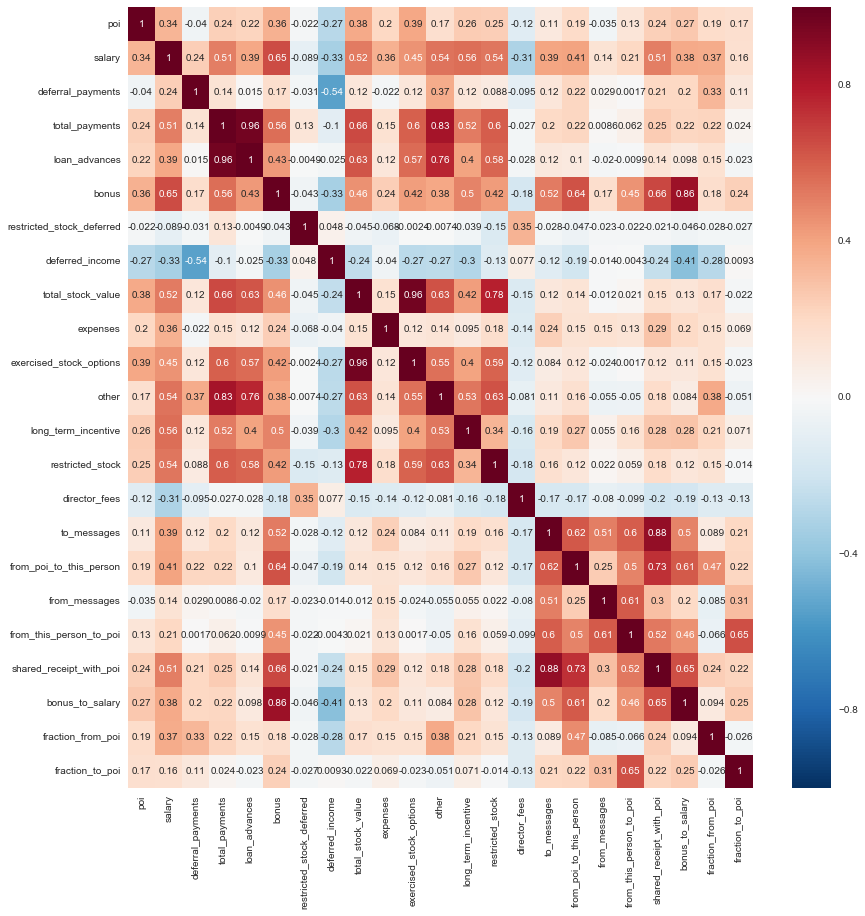

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)
corrplot = df.corr()
sns.heatmap(corrplot, annot=True);
plt.show()

The features with the strongest correlation to POI are:
* Exercised Stock Options
* Total Stock Value
* Bonus
* Salary

These correlations will be useful later on when I decide which features to use when I train my classification algorithms.

Next I will make some scatterplots of feature pairs to see their relationships and how they differ for POIs and non-POIs. The green dots represent POIs and the blue dots represent non-POIs.

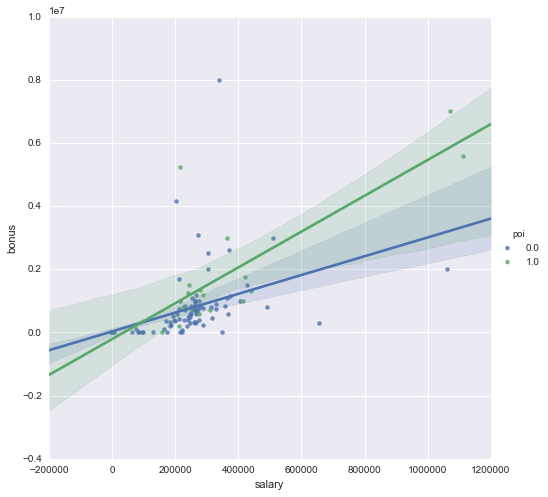

In [111]:
sns.lmplot(x='salary',y='bonus', hue='poi', data=df, size = 7);

The following observations can be made from the above plot:
* The employee with the highest bonus, does not have a high salary, and is not a POI
* Of the three employees with the highest salaries, the two with the highest bonuses are POIs

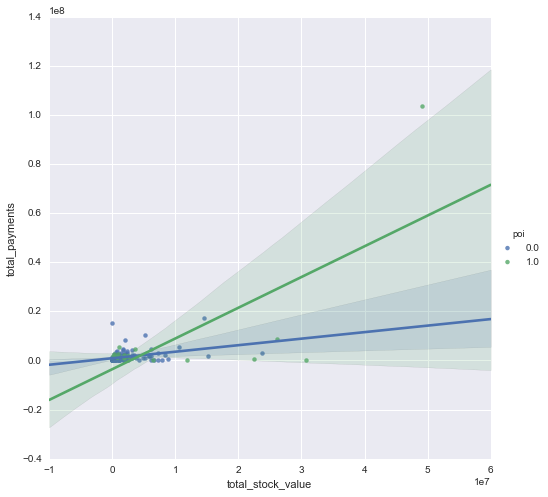

In [112]:
sns.lmplot(x='total_stock_value',y='total_payments', hue='poi', data=df, size = 7);

The above plot show that there is one outlier in the dataset with total payments and total stock values which are significantly higher than any other employee in the data set. This person does happen to be a POI, but since his numbers are so much higher than the rest of the employees, they are not representative of the dataset and will probably skew the results of the predictive model. 

Next I am going to identify who this outlier is, then I will remove them from the data set and see if changes the correlation numbers at all.

In [113]:
# Check who is the person with the highest total payments
for key in my_dataset.keys():
    if not my_dataset[key]['total_payments']=='NaN':
        if my_dataset[key]['total_payments']>100000000:
            print "The outlier in the data set is {}.".format(key)

The outlier in the data set is LAY KENNETH L.


In [114]:
my_dataset.pop("LAY KENNETH L", None)

{'bonus': 7000000,
 'bonus_to_salary': 6.527896031132468,
 'deferral_payments': 202911,
 'deferred_income': -300000,
 'director_fees': 'NaN',
 'exercised_stock_options': 34348384,
 'expenses': 99832,
 'fraction_from_poi': 3.4166666666666665,
 'fraction_to_poi': 0.003744441844137608,
 'from_messages': 36,
 'from_poi_to_this_person': 123,
 'from_this_person_to_poi': 16,
 'loan_advances': 81525000,
 'long_term_incentive': 3600000,
 'other': 10359729,
 'poi': True,
 'restricted_stock': 14761694,
 'restricted_stock_deferred': 'NaN',
 'salary': 1072321,
 'shared_receipt_with_poi': 2411,
 'to_messages': 4273,
 'total_payments': 103559793,
 'total_stock_value': 49110078}

In [115]:
df = df[df['total_payments'] < 100000000]
len(df)

142

Now that the outlier has been removed, I am going to produce the correlation matrix again and see if the numbers have changed.

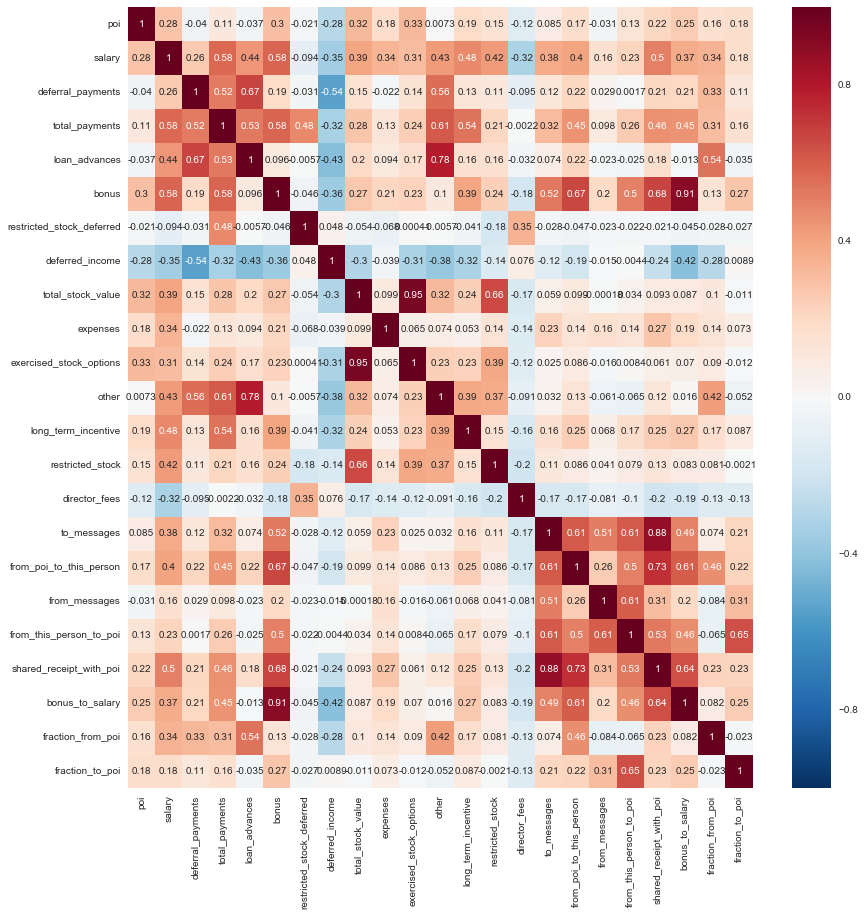

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)
corrplot = df.corr()
sns.heatmap(corrplot, annot=True);
plt.show()

The correlation numbers have in fact changed, which means the values were being effected by that one outlier. It is still however, mostly the same features which have the strongest correlations with POI.

The next step is to decide which features I am going to use when I begin testing classification algorithms. I will make several feature lists, and test them each on a variety of classifiers, and see where I find the best performance.
* Feature Set 1 will be based on the features which had the highest correlations to POI. I will include Exercised Stock Options but not Total Stock Value because they are so highly correlated with eachother that it is not necessary to use both of them.
* Feature Set 2 will be based on the outcome from measuring feature importances using a classification algorithm on the data.
* Feature Set 3 will include the features which I created from the existing features: Bonus To Salary, Fraction From POI and Fraction To POI.

In [131]:
from sklearn.ensemble import ExtraTreesClassifier
X,y = df[features[1:]],df['poi']
clf = ExtraTreesClassifier()
clf.fit(X,y)
clf.feature_importances_

array([ 0.04439881,  0.02982226,  0.0380489 ,  0.00143193,  0.07805819,
        0.00195526,  0.06150177,  0.11167936,  0.05129319,  0.0922774 ,
        0.04348213,  0.0289518 ,  0.06855044,  0.00291759,  0.02549658,
        0.05214322,  0.00950078,  0.05870048,  0.06154354,  0.05157098,
        0.04580108,  0.04087431])

In [118]:
features1 = ['poi','bonus','exercised_stock_options','salary']
features2 = ['poi','bonus','exercised_stock_options','expenses','deferred_income','fraction_to_poi','restricted_stock']
features3 = ['poi','bonus_to_salary','fraction_to_poi','fraction_from_poi']

Finally before I begin training the classifiers on the feature sets, I need to choose which evaluation metrics I will use to determine the performance of an algorithm.
* Precision is defined as the number of true positives divided by the number of true postives plus false positives. A result with fewer false positives will have a higher precision score.
* Recall is defined as the number of true positives divided by the number of true positives plus false negatives. A result with fewer false negatives will have a higher recall score.
* F1 score takes in to account both of these measures. It is calculated by taking two times the product of precision times recall, divided by the sum of precision plus recall. 

References: https://en.wikipedia.org/wiki/Precision_and_recall    https://en.wikipedia.org/wiki/F1_score

Because I am interested in minimizing both the number of false positives and false negatives, I am going to use F1 score as my main performance metric, while also looking at both precision and recall.

In [119]:
#Test classifiers on features set 1
classifiers = [GaussianNB(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(random_state=333),
               AdaBoostClassifier(random_state=333),
               RandomForestClassifier(random_state=333)]
for clf in classifiers:
    test_classifier(clf, my_dataset, features1)

GaussianNB()
	Accuracy: 0.83131	Precision: 0.42045	Recall: 0.25500	F1: 0.31746	F2: 0.27678
	Total predictions: 13000	True positives:  510	False positives:  703	False negatives: 1490	True negatives: 10297

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.86438	Precision: 0.64757	Recall: 0.26000	F1: 0.37103	F2: 0.29535
	Total predictions: 13000	True positives:  520	False positives:  283	False negatives: 1480	True negatives: 10717

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=333, subsample=1.0, verbose=0,
              warm_start=False)
	Accuracy: 0.80277	Precision: 0.32353	Recall: 0.25850	F1: 0.28738	F2: 0.269

In [120]:
#Test classifiers on features set 2
classifiers = [GaussianNB(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(random_state=333),
               AdaBoostClassifier(random_state=333),
               RandomForestClassifier(random_state=333)]
for clf in classifiers:
    test_classifier(clf, my_dataset, features2)

GaussianNB()
	Accuracy: 0.85250	Precision: 0.47660	Recall: 0.33100	F1: 0.39068	F2: 0.35254
	Total predictions: 14000	True positives:  662	False positives:  727	False negatives: 1338	True negatives: 11273

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.85957	Precision: 0.53864	Recall: 0.11850	F1: 0.19426	F2: 0.14040
	Total predictions: 14000	True positives:  237	False positives:  203	False negatives: 1763	True negatives: 11797

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=333, subsample=1.0, verbose=0,
              warm_start=False)
	Accuracy: 0.83821	Precision: 0.37944	Recall: 0.20850	F1: 0.26912	F2: 0.229

In [121]:
#Test classifiers on features set 3
classifiers = [GaussianNB(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(random_state=333),
               AdaBoostClassifier(random_state=333),
               RandomForestClassifier(random_state=333)]
for clf in classifiers:
    test_classifier(clf, my_dataset, features3)

GaussianNB()
	Accuracy: 0.74240	Precision: 0.00515	Recall: 0.00150	F1: 0.00232	F2: 0.00175
	Total predictions: 10000	True positives:    3	False positives:  579	False negatives: 1997	True negatives: 7421

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.79240	Precision: 0.40952	Recall: 0.08600	F1: 0.14215	F2: 0.10214
	Total predictions: 10000	True positives:  172	False positives:  248	False negatives: 1828	True negatives: 7752

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=333, subsample=1.0, verbose=0,
              warm_start=False)
	Accuracy: 0.78070	Precision: 0.42286	Recall: 0.26450	F1: 0.32544	F2: 0.28592

The classifiers with the best results were:
* GaussianNB on feature set 2. Precision: 0.47660 Recall: 0.33100	F1: 0.39068
* AdaBoostClassifier on feature set 2. F1 score Precision: 0.45263	Recall: 0.32250	F1: 0.37664
* KNeighborsClassifier on feature set 1. Precision: 0.64757	Recall: 0.26000	F1: 0.37103

The best performance so far was GaussianNB on feature set 2, but since GaussianNB does not take any parameters, there is no way to tune the model and improve the performance. I am going to tune the parameters of the other two best performers and see if I can get a F1 score higher than 0.39068.

It is important to tune the parameters of the algorithms because some of them are highly optimizeable and the default parameters will rarely give you the best result. In this problem, a false positive means some was falsely classified as a POI when they are in fact not a POI. A false negative means that someone was labelled as not being a POI when in fact they are. Neither of these are a desirable result and by tuning the parameters hopefully we can decrease the number of incorrectly labelled employees.

In [125]:
# Tune the KNeighborsClassifier on feature set 1
n_neighbors = [3,4,5,6,7]
weights = ['uniform','distance']

for i in n_neighbors:
    for j in weights:
        clf = KNeighborsClassifier(n_neighbors = i, weights = j)
        test_classifier(clf, my_dataset, features1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
	Accuracy: 0.85754	Precision: 0.57708	Recall: 0.27700	F1: 0.37432	F2: 0.30915
	Total predictions: 13000	True positives:  554	False positives:  406	False negatives: 1446	True negatives: 10594

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')
	Accuracy: 0.82954	Precision: 0.42286	Recall: 0.29600	F1: 0.34824	F2: 0.31489
	Total predictions: 13000	True positives:  592	False positives:  808	False negatives: 1408	True negatives: 10192

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
	Accuracy: 0.86362	Precision: 0.67930	Recall: 0.21500	F1: 0.32662	F2: 0.24904
	Total predictions: 13000	True positives:  43

In [128]:
# Tune the parameters of the AdaBoostClassifier on feature set 2
n_estimators = [25,50,75]
learning_rate = [.1,1]
for i in n_estimators:
    for j in learning_rate:
        clf = AdaBoostClassifier(random_state=3746, n_estimators = i, learning_rate = j)
        test_classifier(clf, my_dataset, features2)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=25, random_state=3746)
	Accuracy: 0.85614	Precision: 0.48659	Recall: 0.12700	F1: 0.20143	F2: 0.14903
	Total predictions: 14000	True positives:  254	False positives:  268	False negatives: 1746	True negatives: 11732

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=25, random_state=3746)
	Accuracy: 0.84793	Precision: 0.45579	Recall: 0.33250	F1: 0.38450	F2: 0.35152
	Total predictions: 14000	True positives:  665	False positives:  794	False negatives: 1335	True negatives: 11206

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=3746)
	Accuracy: 0.85857	Precision: 0.51289	Recall: 0.19900	F1: 0.28674	F2: 0.22675
	Total predictions: 14000	True positives:  398	False positives:  378	False negatives: 1602	True negatives: 11622

AdaBoostClassifier(algorithm='SAMME.R', base_est

Now how do I know that my result is valid? The test_classifier function uses a method called cross-validation, which means that the model is tested in multiple rounds, and in each round a different section of the dataset is held out from training the algorithm, and is used to validate the result after training. This process is repeated over a set number of rounds where each time a different portion of the dataset is held out of training and is used for testing. 

This process of validation is important because it prevents against overfitting or overtraining the algorithm. An overtrained algorithm gets really accurate at predicting the values in the training set but will struggle to make predictions on the test set. It is always important to use some kind of validation technique to ensure that your resulting model will be robust at predicting new data sets that it was not trained on.

After tuning the parameters of the KNeighborsClassifier and the AdaBoostClassifier I was able to achieve the following results with the KNeighborsClassifier:
* Precision: 0.70049
* Recall: .35550
* F1 Score: 0.47164

The parameters of my final classifier are below, along with the final feature list it was trained on.

In [123]:
# Final Classifier:
final_clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')
# Final Feature List:
final_features = ['poi','bonus','exercised_stock_options','salary']

In [124]:
# Show the final result:
test_classifier(final_clf, my_dataset, final_features)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')
	Accuracy: 0.87746	Precision: 0.70049	Recall: 0.35550	F1: 0.47164	F2: 0.39434
	Total predictions: 13000	True positives:  711	False positives:  304	False negatives: 1289	True negatives: 10696



In [129]:
dump_classifier_and_data(final_clf, my_dataset, final_features)